# aSPEM Experiment : analysis


Test de différtentes pentes $k$ pour la relation entre $p_bet$ et $\hat{p}$


In [1]:
%run ../0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

In [5]:
def sigmoid(y):
    return 1 / (1 + np.exp(-y))
def logit(p):
    return np.log(p / (1 - p))

/home/phantom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/phantom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


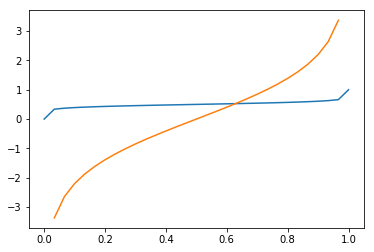

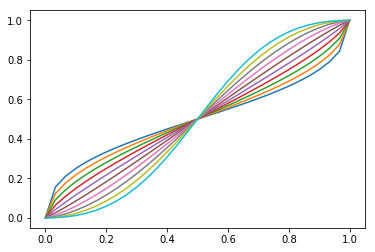

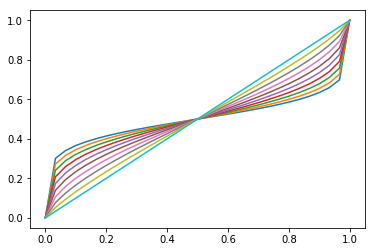

In [6]:
p = np.linspace(0, 1, 31)
plt.plot(p, sigmoid(.2*logit(p)))
plt.plot(p, logit(p))
plt.show()

for k in np.logspace(-1, 1, 10, base=2):
    plt.plot(p, sigmoid(k*logit(p)))
plt.show()

for k in np.logspace(-2, 0, 10, base=2):
    plt.plot(p, sigmoid(k*logit(p)))
plt.show()

In [7]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [8]:
def find_h_r(recording, pourcentage=0.99) :
    Full = e.Full_list(modes_bcp=[])
    modes_bcp = 'mean'
    list_h = recording['list_h']

    r_k_s, h_k_s = {}, {}
    for num, s in enumerate(list(set(Full.sujet))):
        print(s, end=' ')

        bet = Full['results'][Full.sujet==s].values.tolist()
        x = np.array(Full['bino'][Full.sujet==s].values.tolist())

        r_k, h_k = [], []
        for k in range(11) : r_k.append([]) ; h_k.append([])

        for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :

            r_bet_l, r_bet_ = recording['r_bet_k'][s][k], recording['r_bet_k'][s]['sslogit']

            if num==0 :
                #r_k[0]=np.max(r_bet_)
                #h_k[0]=list_h[np.argmax(r_bet_)]   
                if np.argmax(r_bet_)==len(list_h)-1 : #pourcentage
                    for x in range(len(r_bet_)) :
                        if np.round(r_bet_[x], 4)==np.round(pourcentage*np.max(r_bet_), 4) :
                            r_k[0]=r_bet_[x]
                            h_k[0]=list_h[x]
                else : 
                    r_k[0]=np.max(r_bet_)
                    h_k[0]=list_h[np.argmax(r_bet_)]

            #r_k[num+1]=np.max(r_bet_l)
            #h_k[num+1]=list_h[np.argmax(r_bet_l)]
            if np.argmax(r_bet_l)==len(list_h)-1 : #pourcentage
                for x in range(len(r_bet_l)) :
                    if np.round(r_bet_l[x], 4)==np.round(pourcentage*np.max(r_bet_l), 4) :
                        r_k[num+1]=r_bet_l[x]
                        h_k[num+1]=list_h[x]
            else : 
                r_k[num+1]=np.max(r_bet_l)
                h_k[num+1]=list_h[np.argmax(r_bet_l)]

        h_k_s[s], r_k_s[s] = h_k, r_k
    return h_k_s, r_k_s

Plot de R en fonction de la pente

In [9]:
def fig_R_pente(h_k_s, r_k_s, r=True) :
    fig, ax = plt.subplots(1,2,figsize=(2*10,10))

    list_k = np.logspace(-1, 1, 10, base=2)
    print('\n\t\tsans logit|avec logit (max r)\n')
    print('-'*85)

    for num, s in enumerate(h_k_s.keys()) :
        h_k, r_k = np.array(h_k_s[s]), np.array(r_k_s[s])

        r_m   = np.max(r_k)
        arg_m = np.argmax(r_k)
        h_m   = h_k[arg_m]

        if arg_m==0 : k_m = 1
        else :       k_m = list_k[arg_m-1]

        print('%s\tk:\t         |%.3f'%(s, k_m))
        print('\th(tau):\t%.3f(%.0f)|%.3f(%.0f)'%(h_k[0], 1/h_k[0], h_m, 1/h_m))
        print('\tr:\t%.3f    |%.3f'%(r_k[0], r_m))
        print('-'*85)

        ax[0].plot(list_k, r_k[1:])
        ax[1].plot(list_k, h_k[1:])

    if r==True :
        ax[0].set_ylim(-0.1, 1.1)
        ax[1].set_ylim(-0.01, 0.31)

        ax[0].set_title('R') ; ax[1].set_title('H')
        ax[0].set_ylabel('R') ; ax[1].set_ylabel('H')
        
    else :
        ax[0].set_title('MI') ; ax[1].set_title('H')
        ax[0].set_ylabel('MI') ; ax[1].set_ylabel('H')
        
    
    for a in range(2) : ax[a].legend() ; ax[a].set_xlabel('pente')
    plt.show()

In [10]:
def plot_R(recording, list_x, xlabel, pourcentage=0.99, r=True):
    Full = e.Full_list(modes_bcp=[])

    fig, ax = plt.subplots(4,3,figsize=(3*5,4*5))

    r_k_s, h_k_s = {}, {}
    for num_s, s in enumerate(list(set(Full.sujet))):
        print(s, end=' ')

        a, b = num_s//3, num_s%3

        r_k, h_k = [], []
        for k in range(11) : r_k.append([]) ; h_k.append([])

        for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :

            r_bet_l, r_bet_ = recording['r_bet_k'][s][k], recording['r_bet_k'][s]['sslogit']

            if num==0 : ax[a][b].plot(list_x, r_bet_, lw=1)
            ax[a][b].plot(list_x, r_bet_l, lw=1)

            if xlabel=='tau' :
                if s in ['AM', 'SR']:
                    if num==0 :
                        print(np.max(r_bet_), list_x[np.argmax(r_bet_)])
                        p = np.round(pourcentage*np.max(r_bet_), 4)
                        for x in range(len(r_bet_)) :
                            if np.round(r_bet_[x], 4)==p :
                                print('p', p,'x', x, list_x[x])
                        ax[a][b].hlines(p, 0,600)

        ax[a][b].set_title(s, fontsize=20)
        if r==True :
            ax[a][b].set_ylim(0,1)
            ax[a][b].set_ylabel('r', fontsize=15)
        else :
            ax[a][b].set_ylabel('MI', fontsize=15)
        ax[a][b].set_xlabel(xlabel, fontsize=15)
    plt.tight_layout()
    plt.show()

# R

CS SR AM 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


OP RS YK BMC IP TN FM LB DC 
		sans logit|avec logit (max r)

-------------------------------------------------------------------------------------
CS	k:	         |0.500
	h(tau):	0.125(8)|0.111(9)
	r:	0.735    |0.742
-------------------------------------------------------------------------------------
SR	k:	         |2.000
	h(tau):	0.005(186)|0.005(208)
	r:	0.877    |0.888
-------------------------------------------------------------------------------------
AM	k:	         |0.926
	h(tau):	0.004(245)|0.004(240)
	r:	0.919    |0.919
-------------------------------------------------------------------------------------
OP	k:	         |0.500
	h(tau):	0.050(20)|0.059(17)
	r:	0.786    |0.794
-------------------------------------------------------------------------------------
RS	k:	         |1.000
	h(tau):	0.006(162)|0.006(162)
	r:	0.647    |0.647
-------------------------------------------------------------------------------------
YK	k:	         |0.583
	h(tau):	0.028(36)|0.032(31)
	r:	0.678   

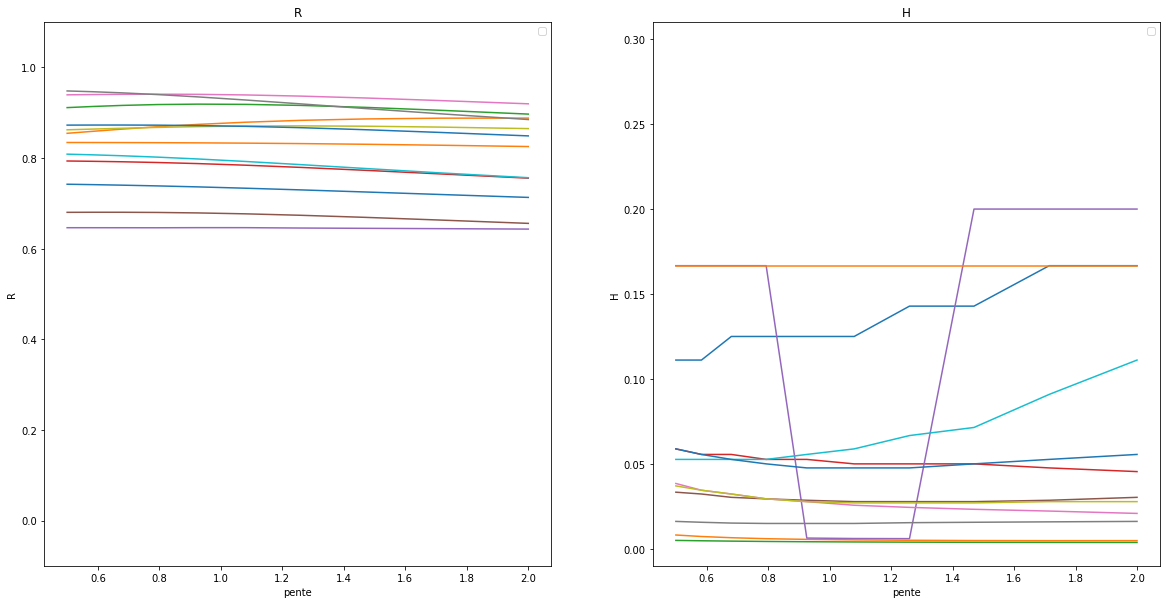

CS SR 0.885707200728995 600.0
p 0.8769 x 184 185.0
p 0.8769 x 185 185.99999999999997
AM 0.9283441419926637 600.0
p 0.9191 x 243 244.0
p 0.9191 x 244 244.99999999999997
OP RS YK BMC IP TN FM LB DC 

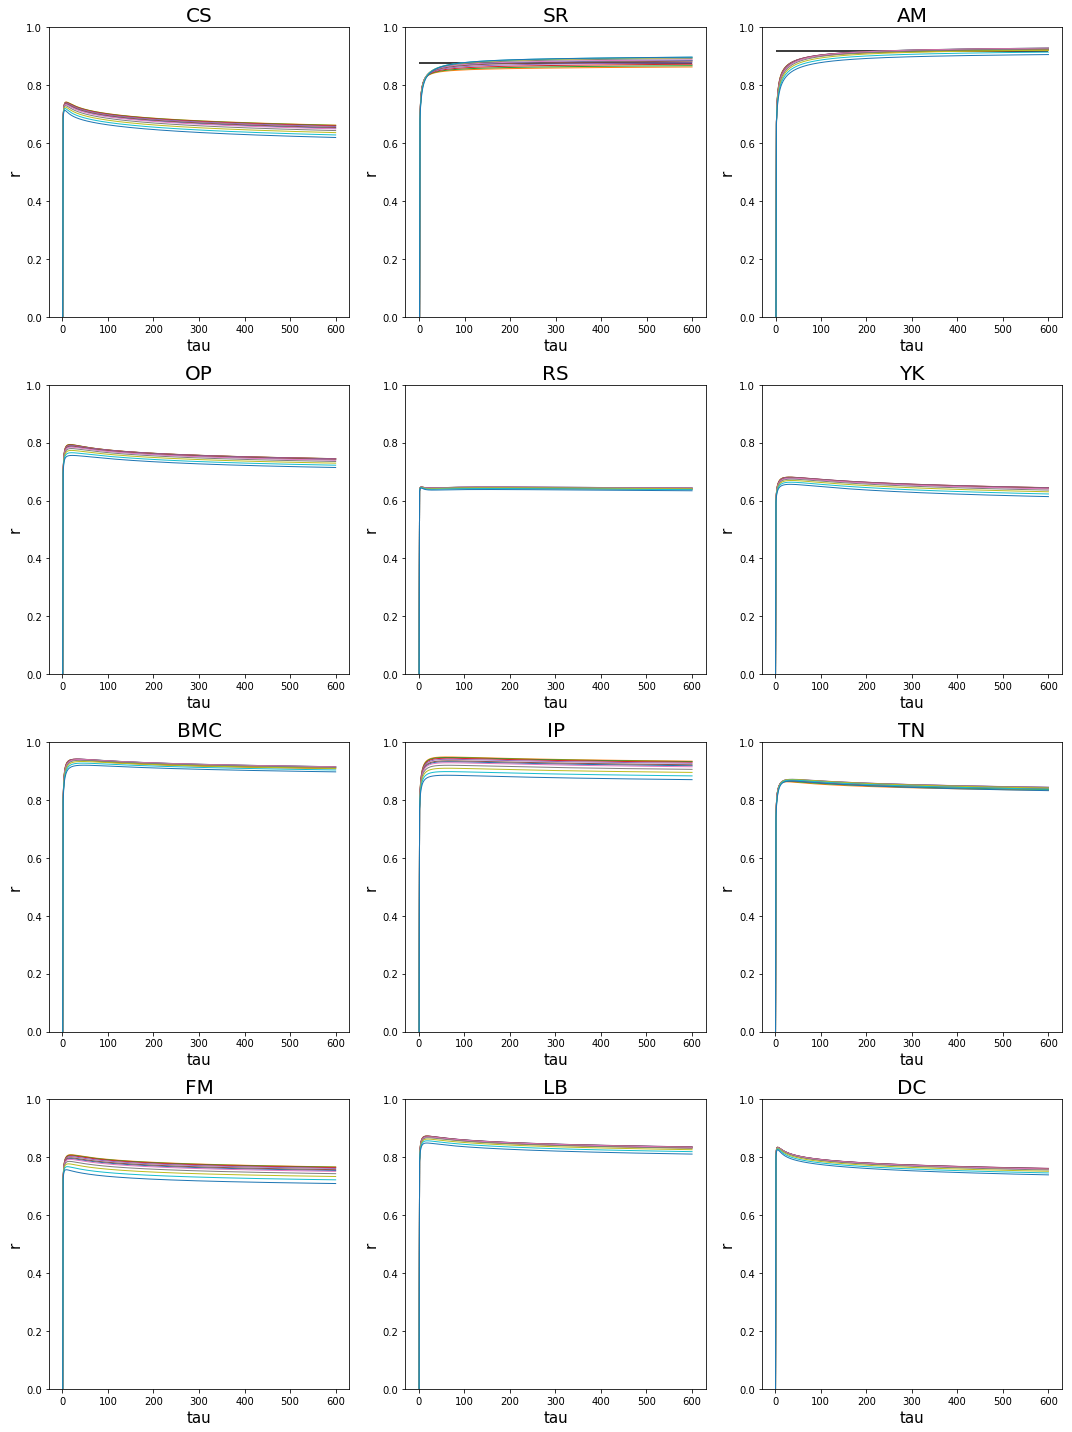

CS SR AM OP RS YK BMC IP TN FM LB DC 

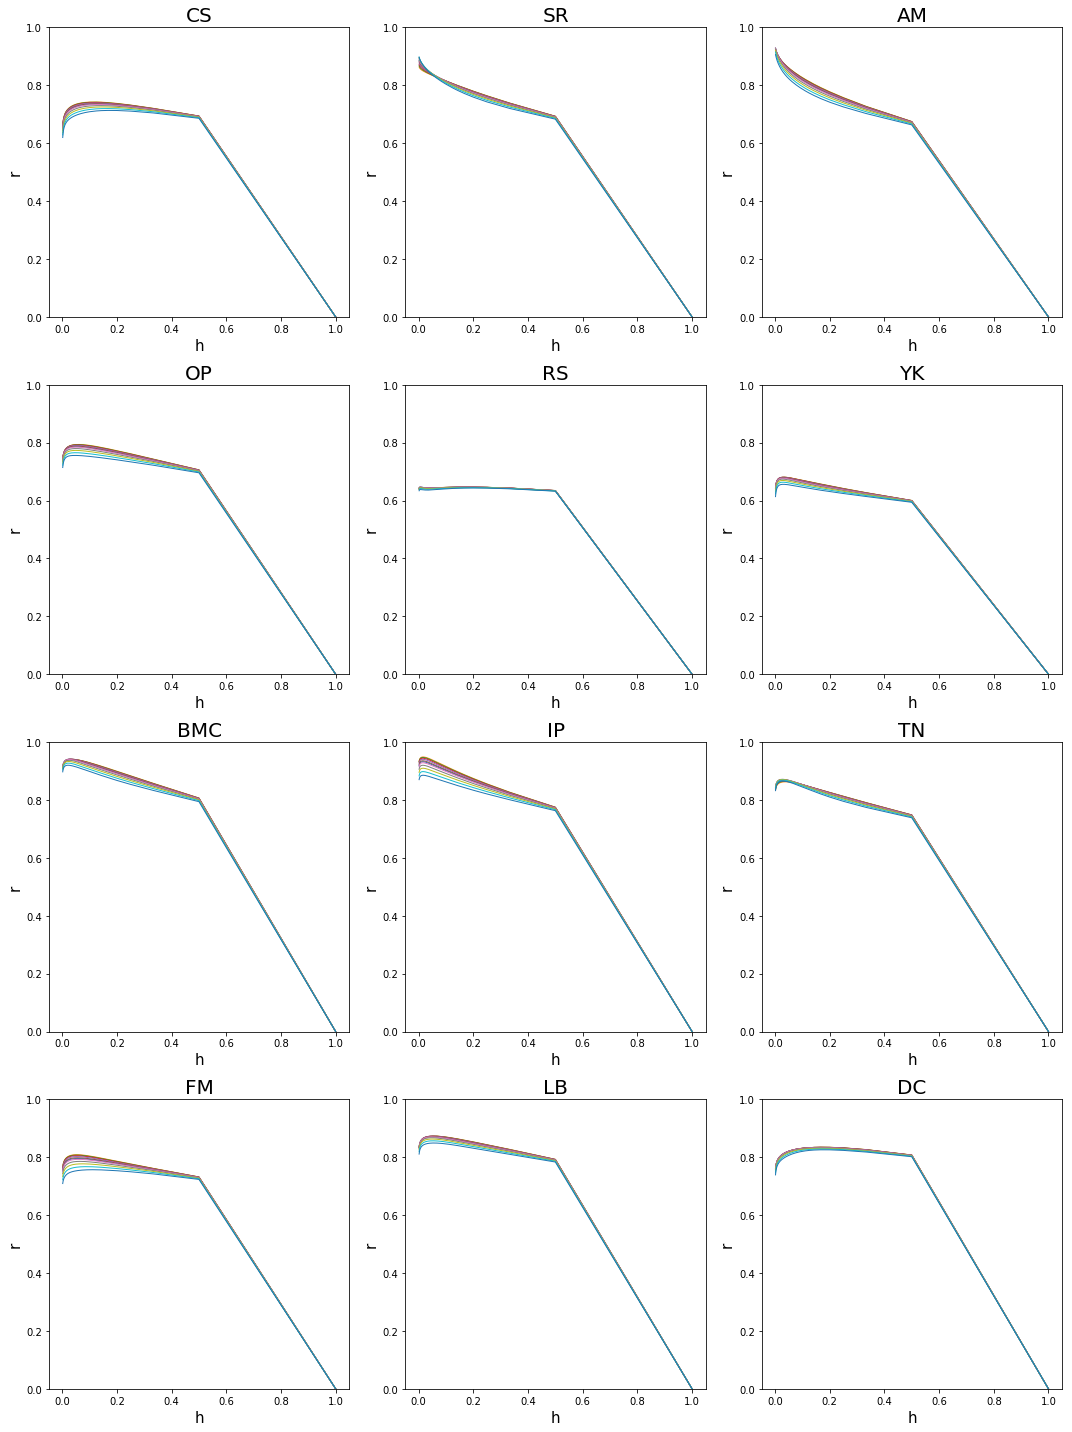

In [11]:
import pickle
file = os.path.join('parametre', 'list_r_bet_logit_600.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
    
h_k_s, r_k_s = find_h_r(recording)
fig_R_pente(h_k_s, r_k_s)
plot_R(recording, 1/recording['list_h'], 'tau') 
plot_R(recording, recording['list_h'], 'h') 

CS SR AM 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


OP RS YK BMC IP TN FM LB DC 
		sans logit|avec logit (max r)

-------------------------------------------------------------------------------------
CS	k:	         |0.500
	h(tau):	0.125(8)|0.111(9)
	r:	0.720    |0.727
-------------------------------------------------------------------------------------
SR	k:	         |2.000
	h(tau):	0.003(309)|0.003(399)
	r:	0.857    |0.876
-------------------------------------------------------------------------------------
AM	k:	         |1.080
	h(tau):	0.004(224)|0.004(232)
	r:	0.929    |0.930
-------------------------------------------------------------------------------------
OP	k:	         |0.500
	h(tau):	0.059(17)|0.067(15)
	r:	0.771    |0.778
-------------------------------------------------------------------------------------
RS	k:	         |0.926
	h(tau):	0.005(219)|0.005(213)
	r:	0.640    |0.641
-------------------------------------------------------------------------------------
YK	k:	         |0.794
	h(tau):	0.022(45)|0.024(41)
	r:	0.672   

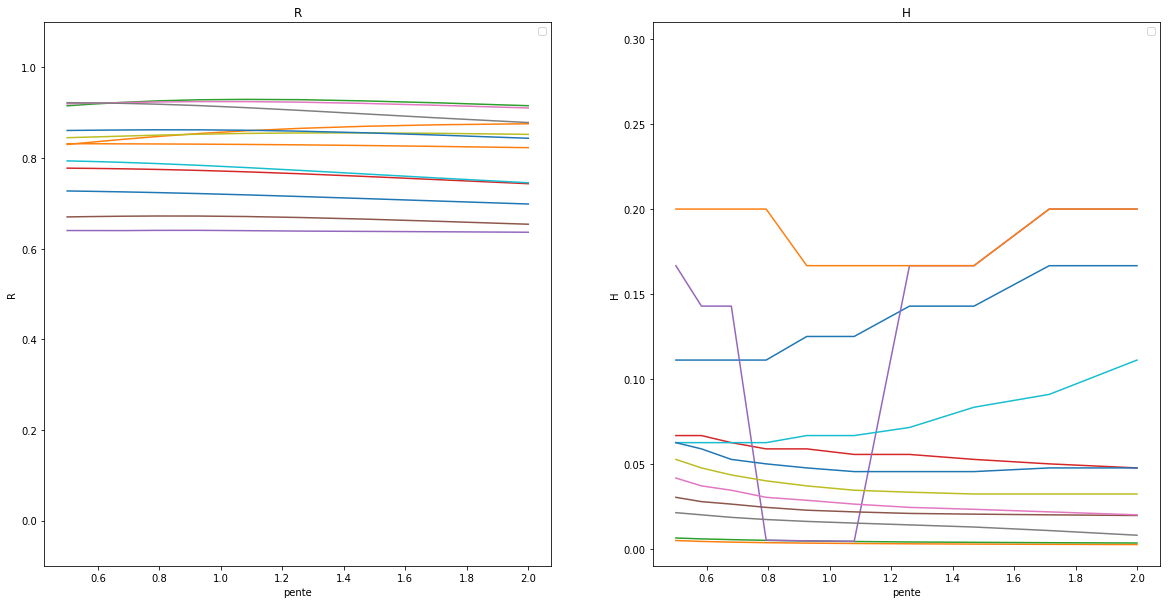

CS SR 0.857262031646397 309.0
p 0.8487 x 71 72.0
AM 0.9387214465621625 600.0
p 0.9293 x 222 223.0
p 0.9293 x 223 224.0
OP RS YK BMC IP TN FM LB DC 

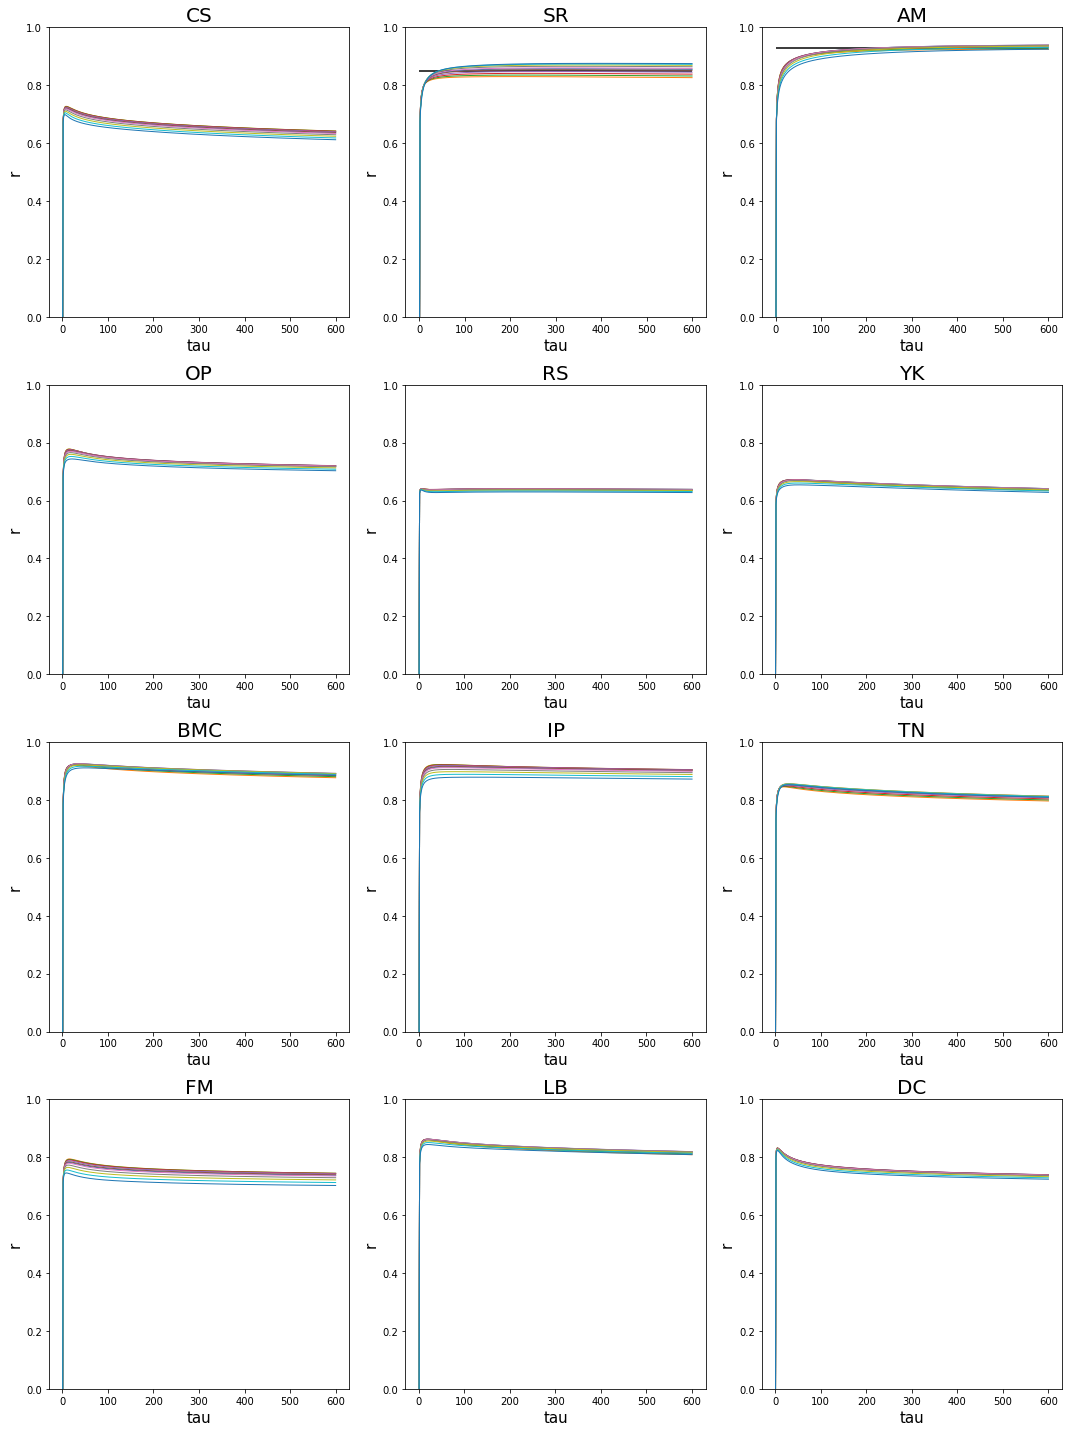

CS SR AM OP RS YK BMC IP TN FM LB DC 

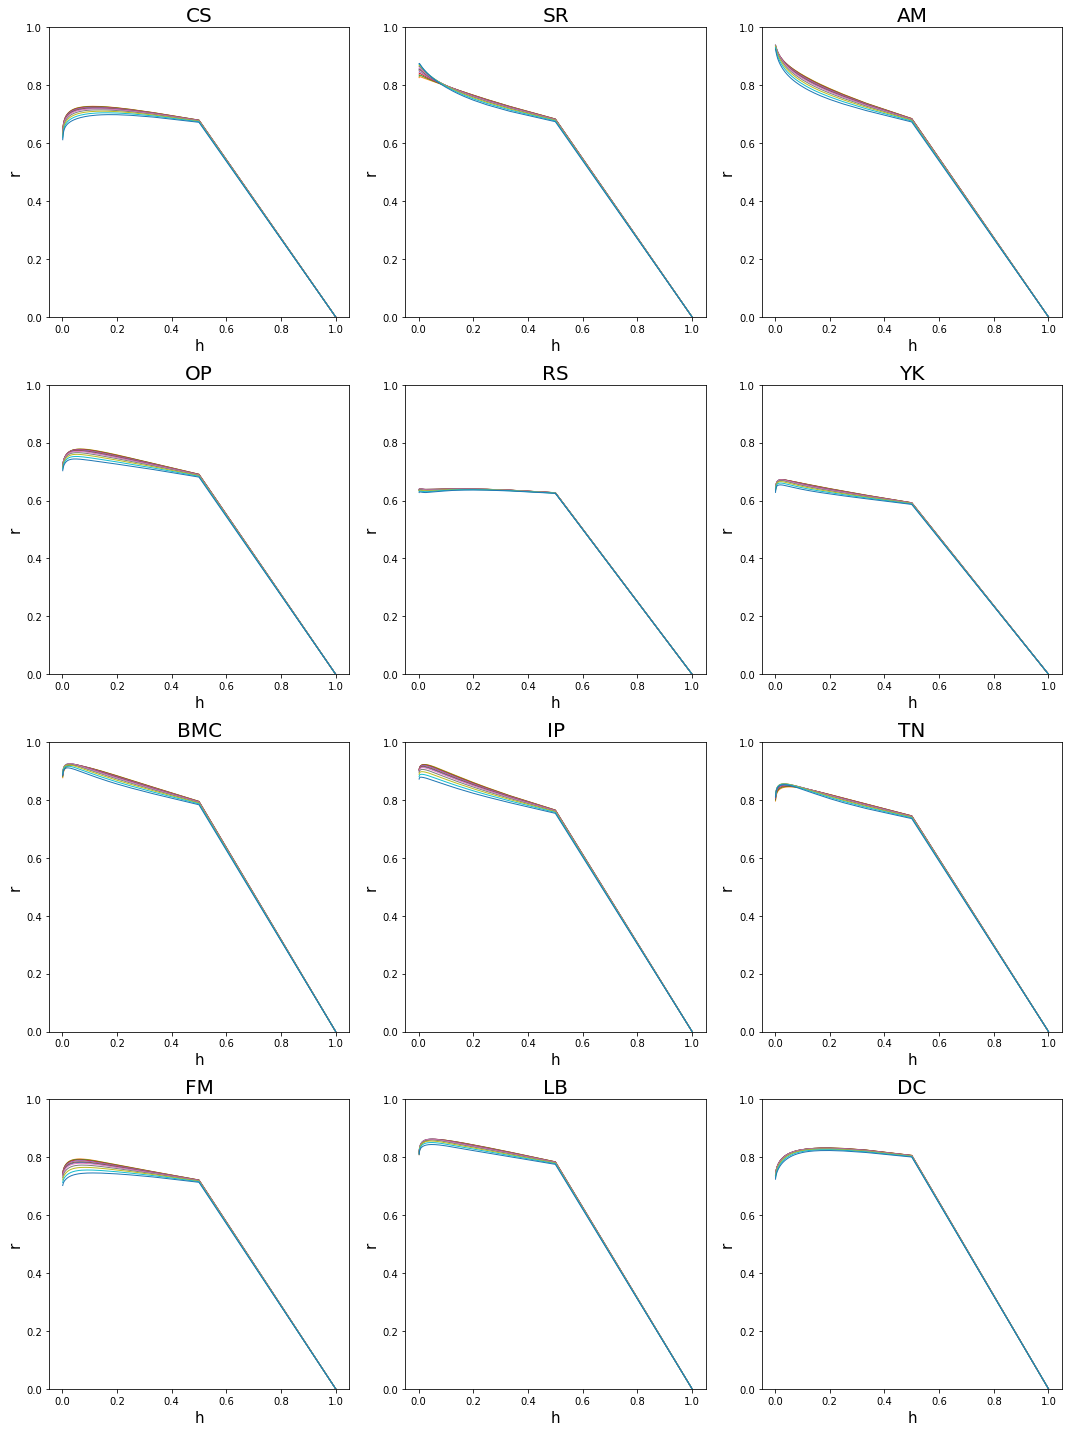

In [12]:
import pickle
file = os.path.join('parametre', 'list_r_bet_logit_600_ss_pauses.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
    
h_k_s, r_k_s = find_h_r(recording)
fig_R_pente(h_k_s, r_k_s)
plot_R(recording, 1/recording['list_h'], 'tau') 
plot_R(recording, recording['list_h'], 'h') 

# MI

No handles with labels found to put in legend.
No handles with labels found to put in legend.


CS SR AM OP RS YK BMC IP TN FM LB DC 
		sans logit|avec logit (max r)

-------------------------------------------------------------------------------------
CS	k:	         |0.500
	h(tau):	0.071(14)|0.077(13)
	r:	0.549    |0.567
-------------------------------------------------------------------------------------
SR	k:	         |1.260
	h(tau):	0.002(523)|0.002(533)
	r:	1.118    |1.148
-------------------------------------------------------------------------------------
AM	k:	         |0.926
	h(tau):	0.002(587)|0.002(577)
	r:	1.284    |1.297
-------------------------------------------------------------------------------------
OP	k:	         |0.500
	h(tau):	0.048(21)|0.091(11)
	r:	0.825    |0.889
-------------------------------------------------------------------------------------
RS	k:	         |0.926
	h(tau):	0.077(13)|0.062(16)
	r:	0.501    |0.501
-------------------------------------------------------------------------------------
YK	k:	         |0.583
	h(tau):	0.011(95)|0.077(13)
	r:

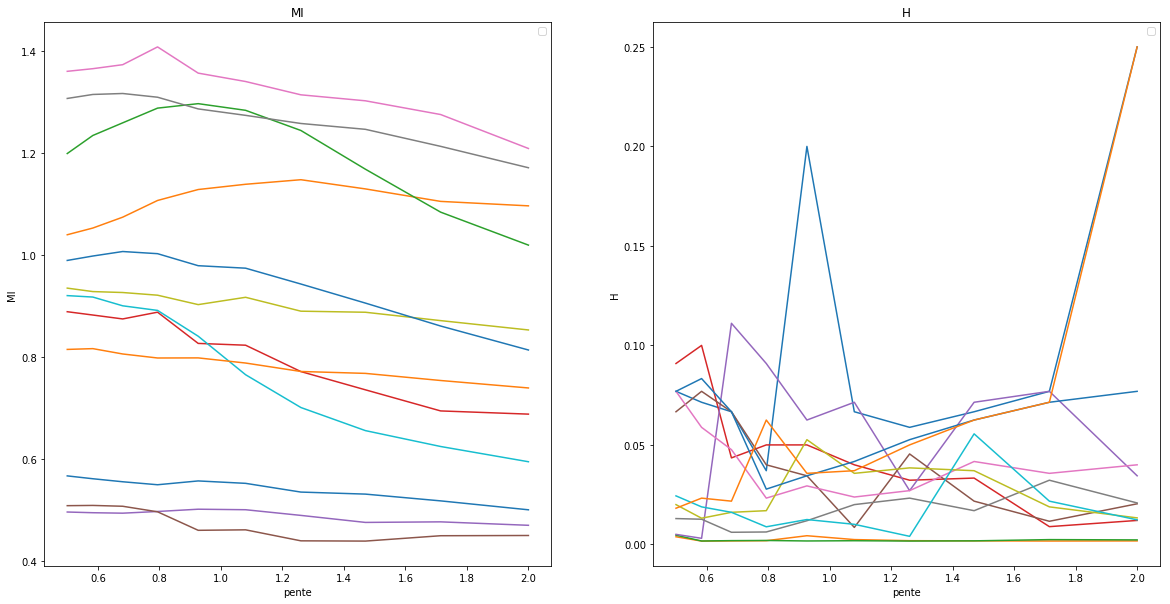

CS SR 1.1182990513198516 523.0
AM 1.2838652812535463 587.0
OP RS YK BMC IP TN FM LB DC 

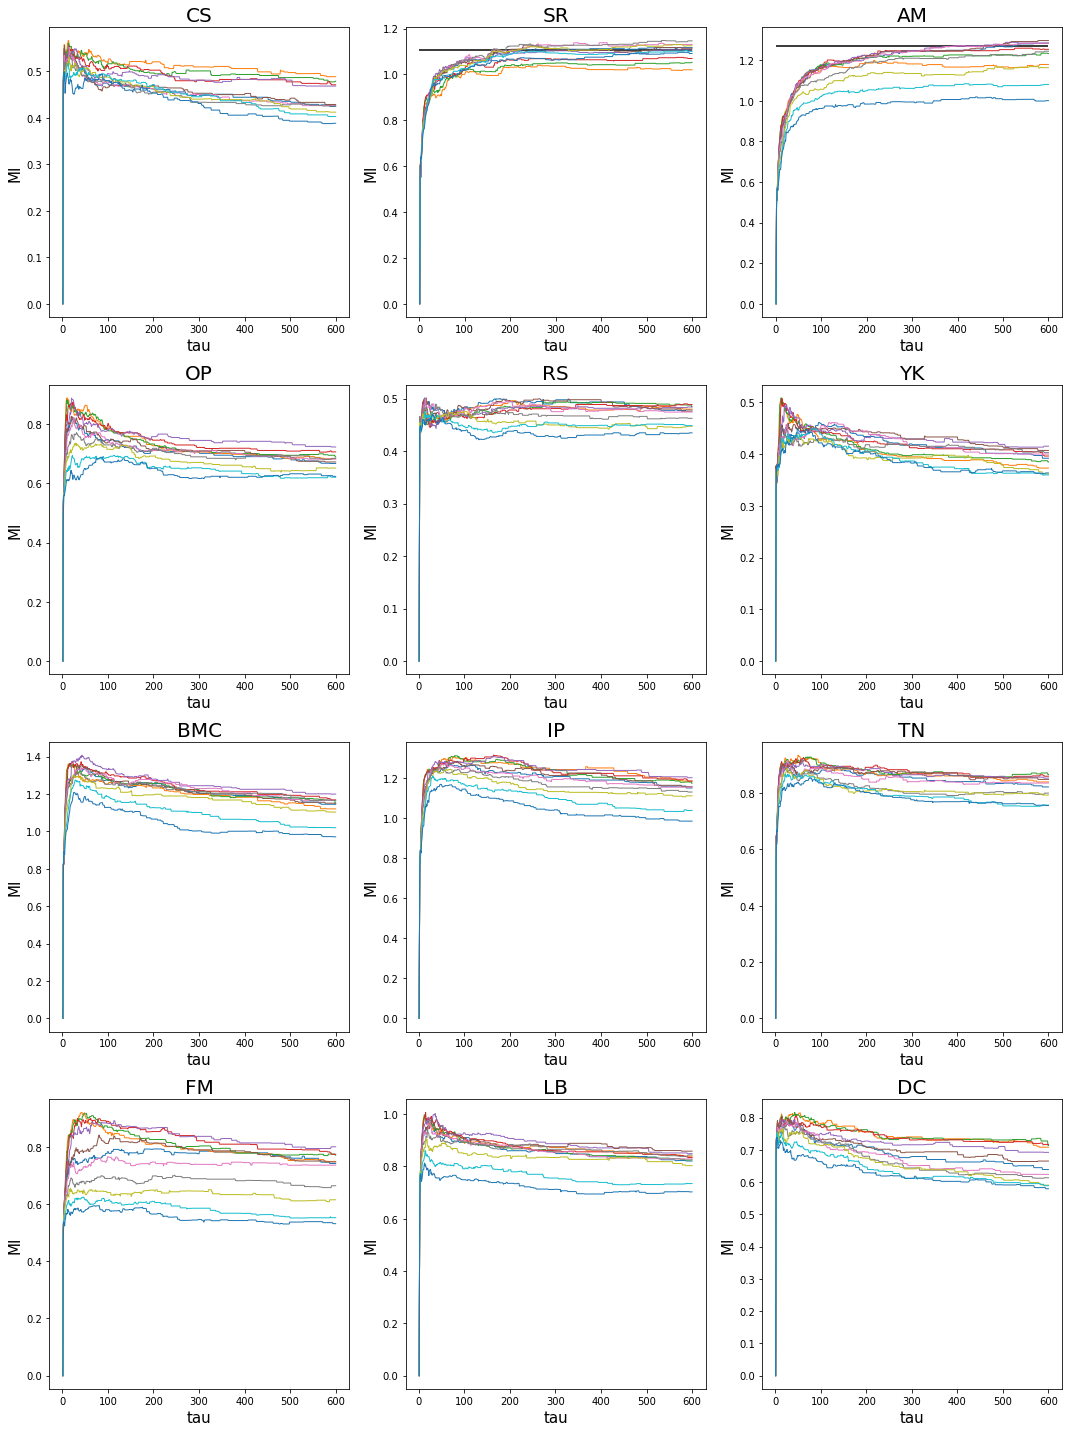

CS SR AM OP RS YK BMC IP TN FM LB DC 

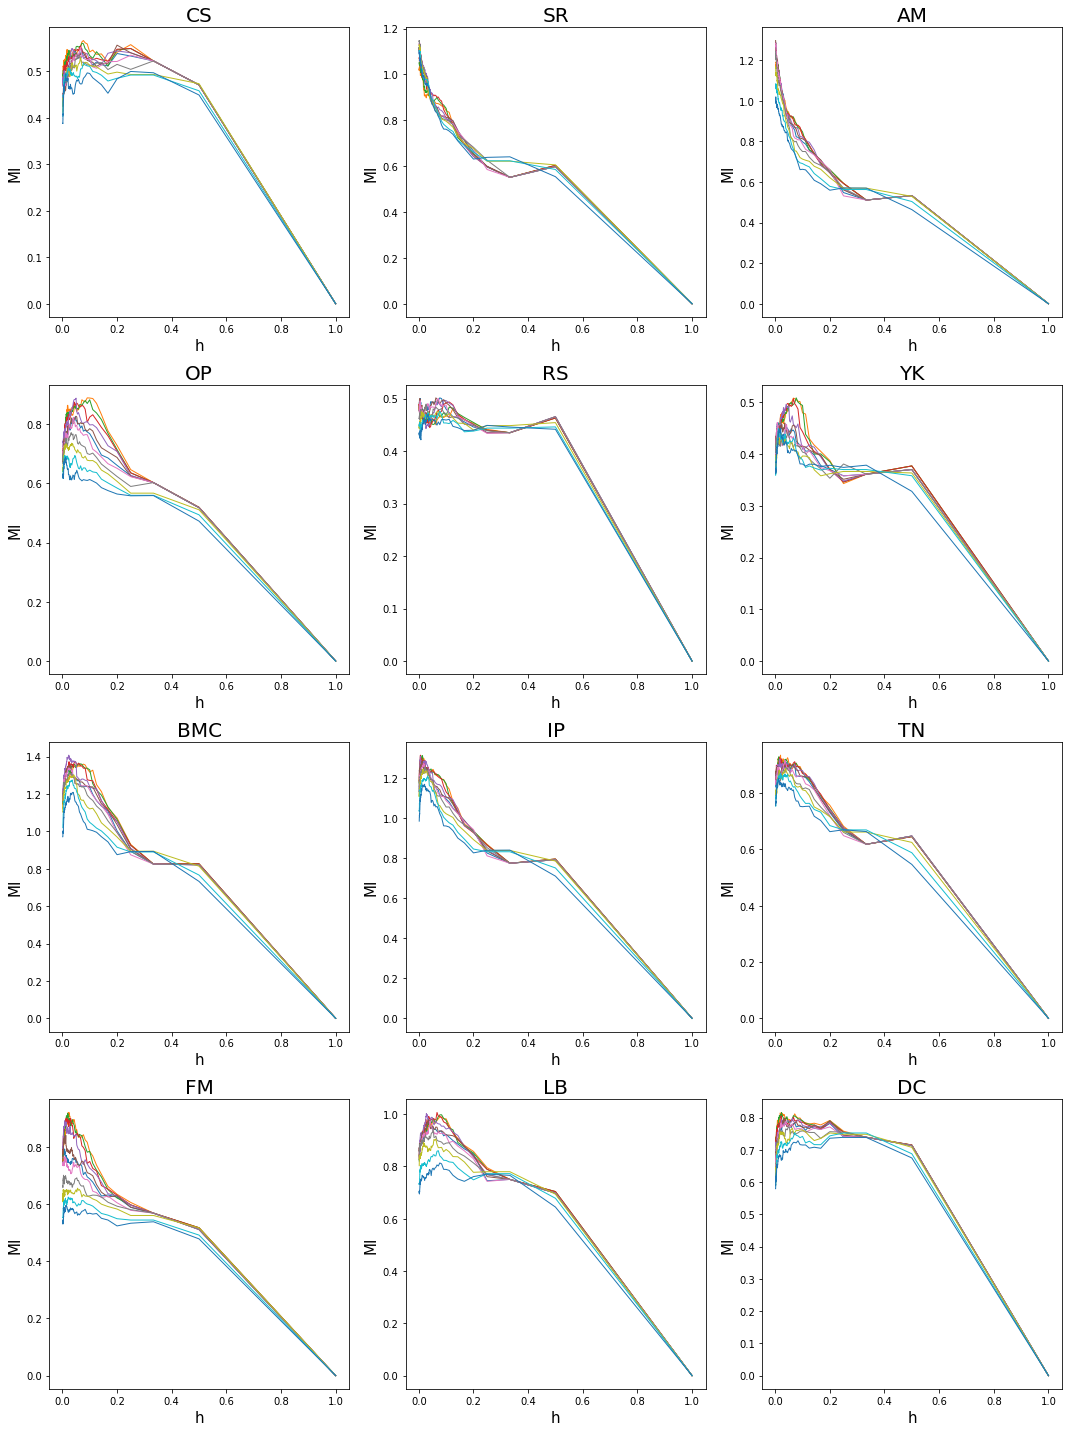

In [13]:
import pickle
file = os.path.join('parametre', 'list_MI_bet_logit_600.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
    
h_k_s, r_k_s = find_h_r(recording)
fig_R_pente(h_k_s, r_k_s, r=False)
plot_R(recording, 1/recording['list_h'], 'tau', r=False) 
plot_R(recording, recording['list_h'], 'h', r=False)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


CS SR AM OP RS YK BMC IP TN FM LB DC 
		sans logit|avec logit (max r)

-------------------------------------------------------------------------------------
CS	k:	         |0.500
	h(tau):	0.067(15)|0.083(12)
	r:	0.530    |0.547
-------------------------------------------------------------------------------------
SR	k:	         |1.080
	h(tau):	0.004(225)|0.004(247)
	r:	1.066    |1.071
-------------------------------------------------------------------------------------
AM	k:	         |0.926
	h(tau):	0.003(389)|0.002(424)
	r:	1.358    |1.381
-------------------------------------------------------------------------------------
OP	k:	         |0.500
	h(tau):	0.045(22)|0.125(8)
	r:	0.787    |0.875
-------------------------------------------------------------------------------------
RS	k:	         |1.000
	h(tau):	0.067(15)|0.067(15)
	r:	0.484    |0.484
-------------------------------------------------------------------------------------
YK	k:	         |0.583
	h(tau):	0.036(28)|0.056(18)
	r:	

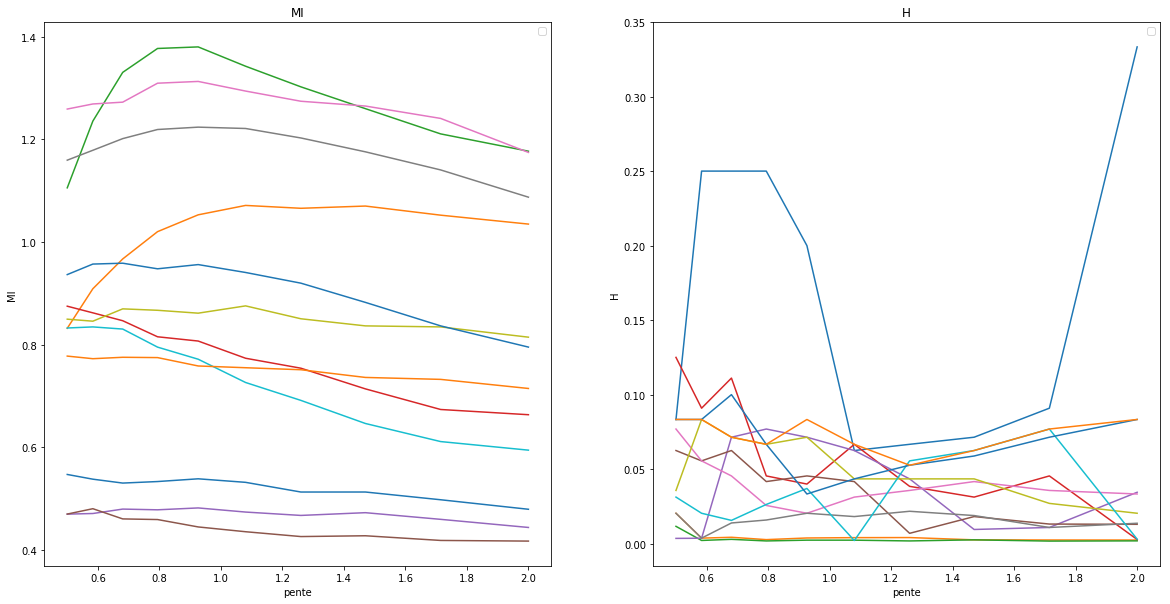

CS SR 1.0658878486180212 225.0
AM 1.3575131179592783 389.0
OP RS YK BMC IP TN FM LB DC 

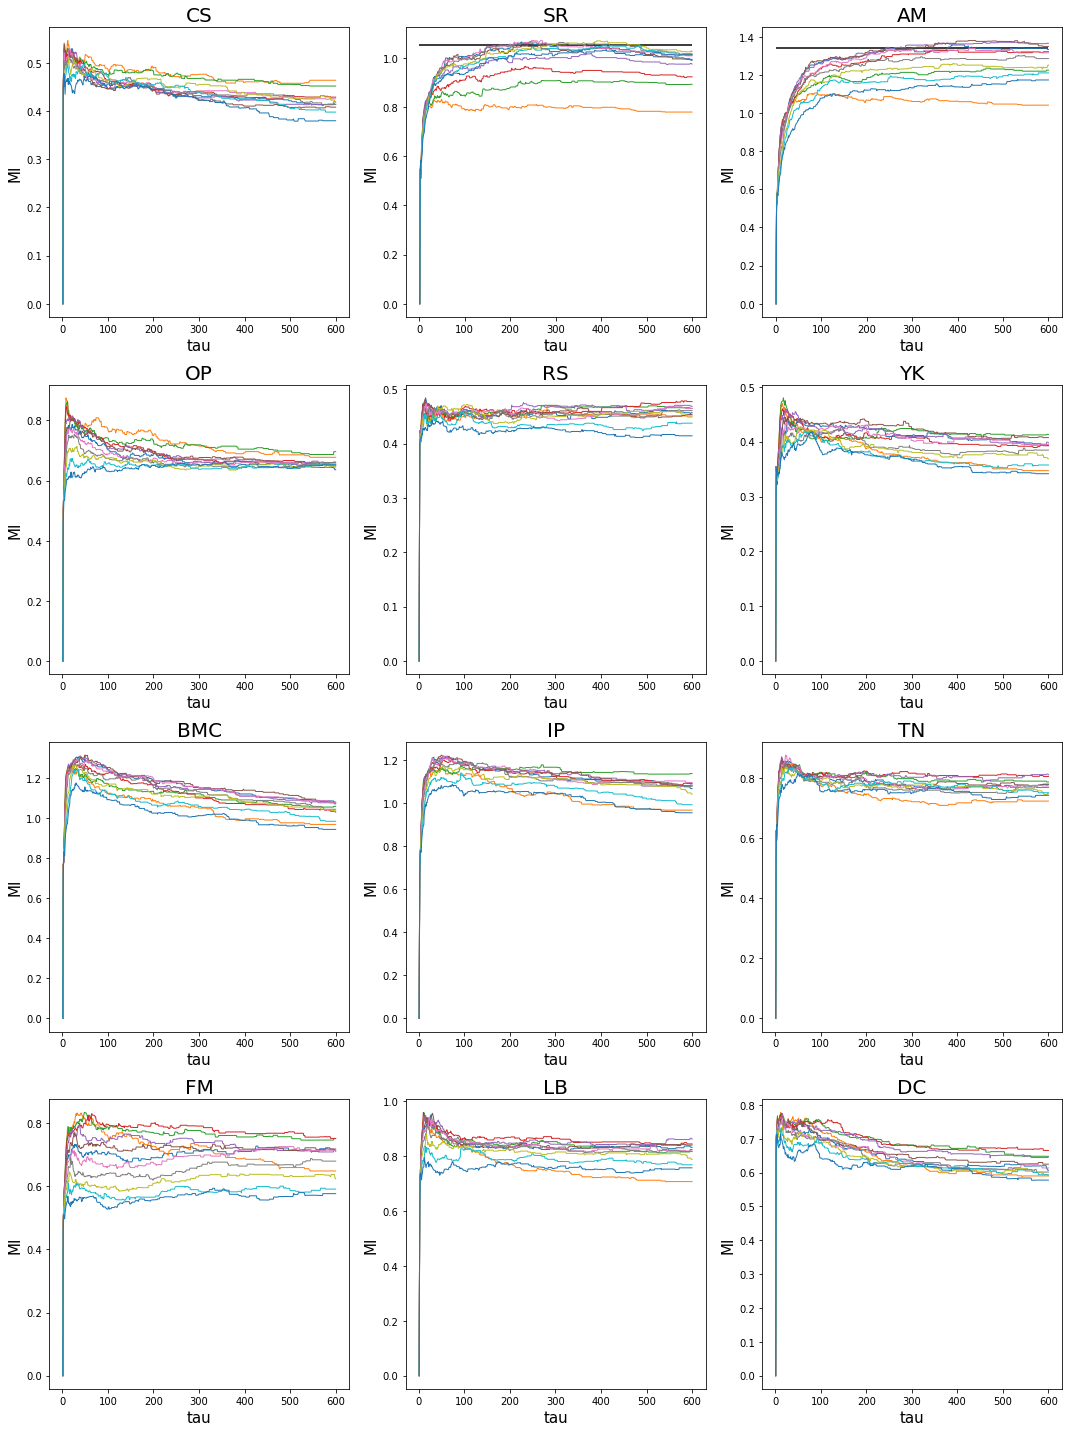

CS SR AM OP RS YK BMC IP TN FM LB DC 

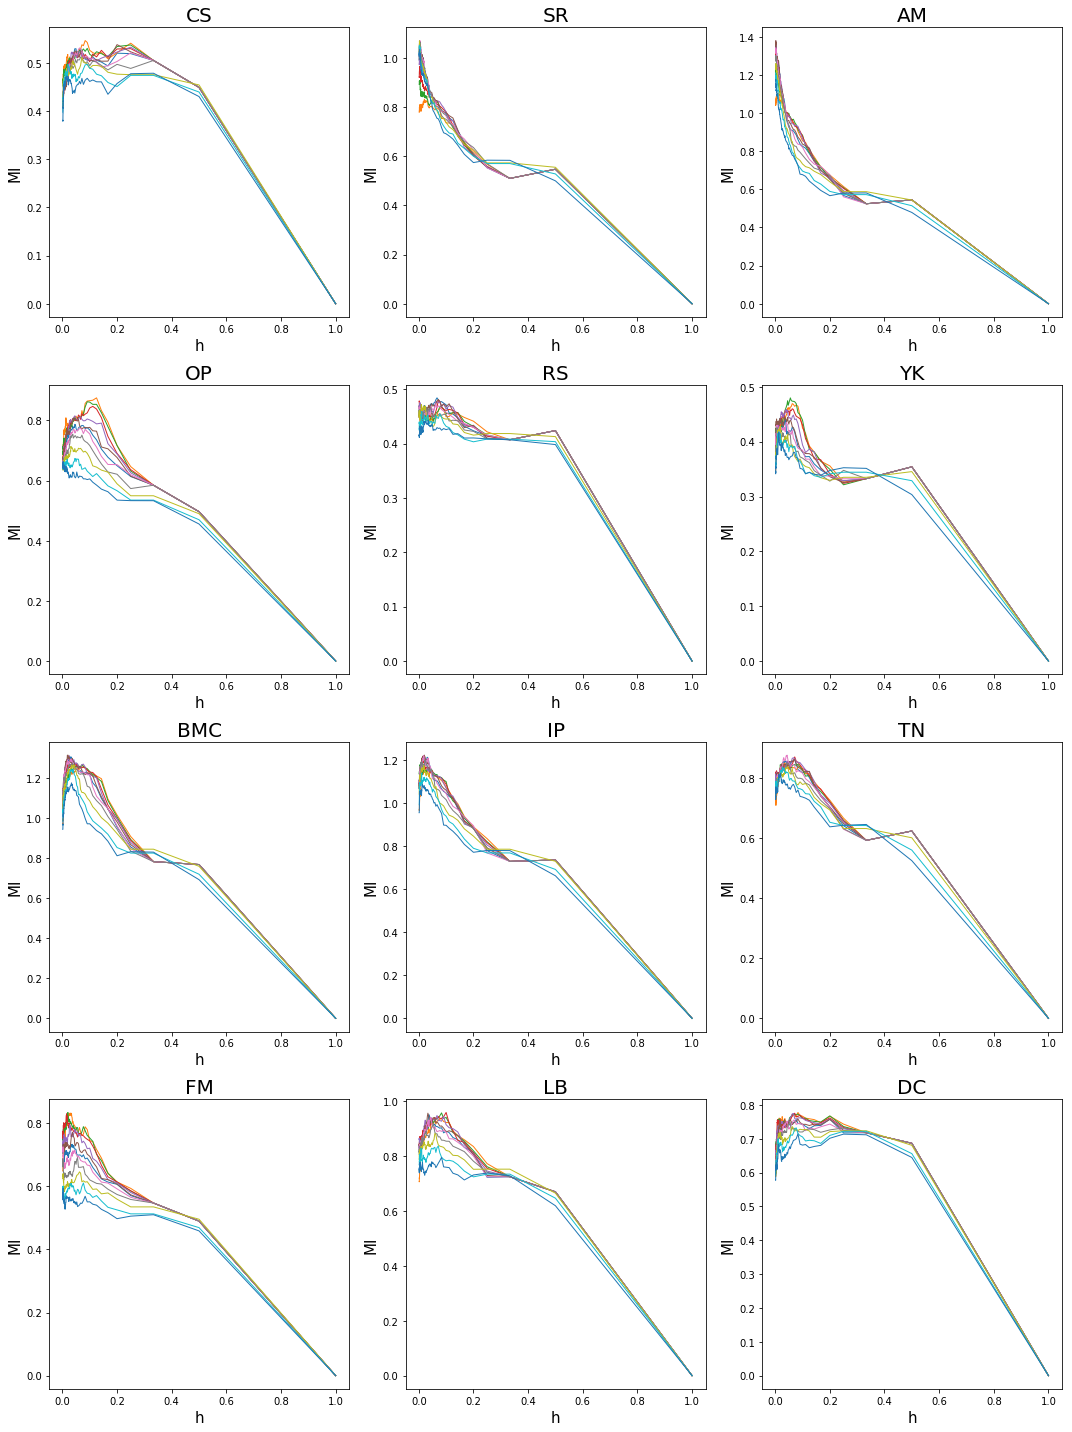

In [14]:
import pickle
file = os.path.join('parametre', 'list_MI_bet_logit_600_ss_pauses.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
    
    
h_k_s, r_k_s = find_h_r(recording)
fig_R_pente(h_k_s, r_k_s, r=False)
plot_R(recording, 1/recording['list_h'], 'tau', r=False) 
plot_R(recording, recording['list_h'], 'h', r=False)